In [2]:
import re
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Get data

In [3]:
dataset_filename = "../../preprocessing/data/processed_merge.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False)

In [3]:
df.head()

,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
0,0,21636,Sandwich,richardson174.cha,okay . [+ exc] 564200_564650,okay.,0
1,1,785,Stroke,adler25a.cha,and I &+b brimɛmbə˞@u [: remember] [* p:n] osp...,and i remember hospital hospital.,1
2,2,14488,Window,capilouto44a.cha,where he is beside him . 1304770_1306020,where he is beside him.,0
3,3,6865,Umbrella,62-1.cha,it's pouring . 794962_795602,it's pouring.,0
4,4,33578,Umbrella,wright34a.cha,&-uh every morning mommy gets Billy ready for ...,every morning mommy gets billy ready for school.,0


In [4]:
# no null values 
df.isnull().sum()

Unnamed: 0.1         0
Unnamed: 0           0
scenario             0
source_file          0
original_text        0
preprocessed_text    0
label                0
dtype: int64

In [5]:
sentences = df["preprocessed_text"]

<Axes: xlabel='label', ylabel='count'>

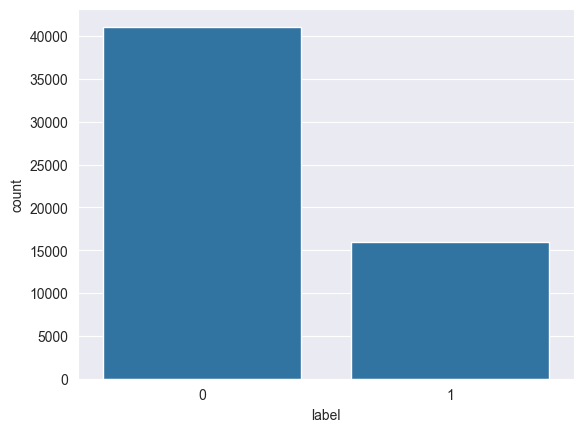

In [6]:
# A bit unbalanced
sns.countplot(x="label",data=df)

In [7]:
input_df = df

In [8]:
input_df

,Unnamed: 0.1,Unnamed: 0,scenario,source_file,original_text,preprocessed_text,label
0,0,21636,Sandwich,richardson174.cha,okay . [+ exc] 564200_564650,okay.,0
1,1,785,Stroke,adler25a.cha,and I &+b brimɛmbə˞@u [: remember] [* p:n] osp...,and i remember hospital hospital.,1
2,2,14488,Window,capilouto44a.cha,where he is beside him . 1304770_1306020,where he is beside him.,0
3,3,6865,Umbrella,62-1.cha,it's pouring . 794962_795602,it's pouring.,0
4,4,33578,Umbrella,wright34a.cha,&-uh every morning mommy gets Billy ready for ...,every morning mommy gets billy ready for school.,0
...,...,...,...,...,...,...,...
57046,57046,28585,Important_Event,UNH1034.cha,something that was so foreign to me to just as...,something that was so foreign to me to just as...,0
57047,57047,27856,Cinderella,UMD24.cha,the prince continues to wave her away . 13682...,the prince continues to wave her away.,0
57048,57048,28812,Cinderella,UNH1034.cha,and she was off to the ball . 1993565_1994535,and she was off to the ball.,0
57049,57049,342,Umbrella,adler11a.cha,yeah &=points:frame_5 . [+ exc] 694075_694992,yeah.,1


# Encoding # 1

In [9]:
import multiprocessing
from gensim.models import Word2Vec

In [10]:
cores = multiprocessing.cpu_count()
cores

16

In [11]:
words_in_sentences=[]
for i in input_df["preprocessed_text"]:
    words_in_sentences.append(re.findall(r"[\w']+|[.,!?;]", i.lower()))
words_in_sentences[20]

['oh', 'maybe', 'mom', 'was', 'right', '.']

In [12]:
input_df.iloc[20]

Unnamed: 0.1                                                    20
Unnamed: 0                                                   26047
scenario                                                  Umbrella
source_file                                              UMD09.cha
original_text        +" oh ‡ maybe mom was right . 116755_118305
preprocessed_text                          oh maybe mom was right.
label                                                            0
Name: 20, dtype: object

In [13]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-10)

In [14]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [15]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4032941, 14997000)

In [16]:
w2v_model.save("word2vec_rf.model")

In [17]:
w2v_model = Word2Vec.load("word2vec_rf.model")

In [18]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

9815


In [19]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [20]:
transformed_text, labels1= avg_w2vec(input_df["preprocessed_text"], input_df["label"])

# Model fitting

In [21]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20, random_state=42)

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100)


In [23]:
forest = forest.fit(x_train, y_train)

In [24]:
rfPickle = open('rf_pickle', 'wb')
pickle.dump(forest, rfPickle)
rfPickle.close()

# Testing plots

In [25]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [26]:
loaded_model = pickle.load(open('rf_pickle', 'rb'))

In [27]:
loaded_model

RandomForestClassifier()

In [28]:
result = loaded_model.predict(x_test)

In [29]:
len(x_test)

10304

In [30]:
len(y_test)

10304

In [31]:
print(accuracy_score(y_test, result))

0.8782026397515528


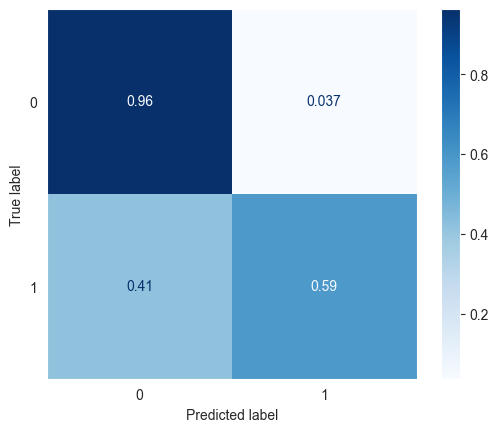

In [32]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [33]:
print(tn, fn, tp, fp)

0.9628378378378378 0.4143598615916955 0.5856401384083045 0.037162162162162164


In [34]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.940330724327571
0.5856401384083045
0.7217639982423408
